In [2]:
import glob
from concurrent.futures import ProcessPoolExecutor

import numpy as np
import pandas as pd
import seaborn as sns
from jass.game.const import card_ids
from tqdm import tqdm


In [86]:
# df = pd.concat([pd.read_json(file, lines=True) for file in glob.glob('../data/swisslos/*.txt')])
df = pd.read_json("../data/swisslos/jass_game_0001.txt", lines=True)
df.head(2)

,game,date,player_ids
0,"{'version': 'V0.2', 'trump': 1, 'dealer': 2, '...",2017-10-13 22:31:05,"[58663, 21516, 41630, 70654]"
1,"{'version': 'V0.2', 'trump': 1, 'dealer': 0, '...",2017-10-13 22:47:34,"[36972, 67618, 5202, 60659]"


In [87]:
player_stats = pd.read_json("../data/swisslos/player_all_stat.json")
player_stats.head(2)

,id,mean,std,nr
0,0,78.433100,42.186764,1978858
1,6955,76.191936,41.780344,4241


<Axes: xlabel='mean', ylabel='Count'>

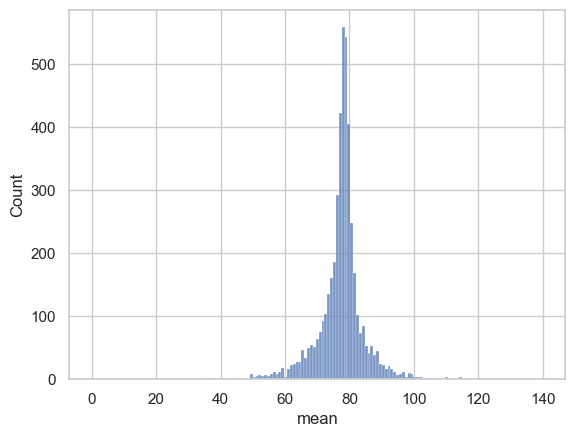

In [88]:
sns.set(style="whitegrid")
sns.histplot(player_stats["mean"], bins=157)

<Axes: xlabel='std', ylabel='Count'>

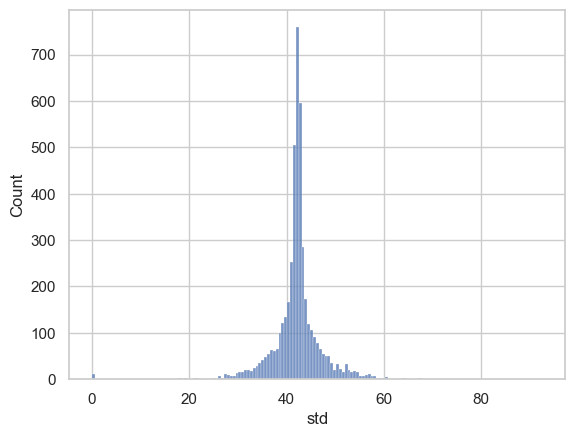

In [89]:
sns.histplot(player_stats["std"], bins=157)

<Axes: xlabel='nr', ylabel='Count'>

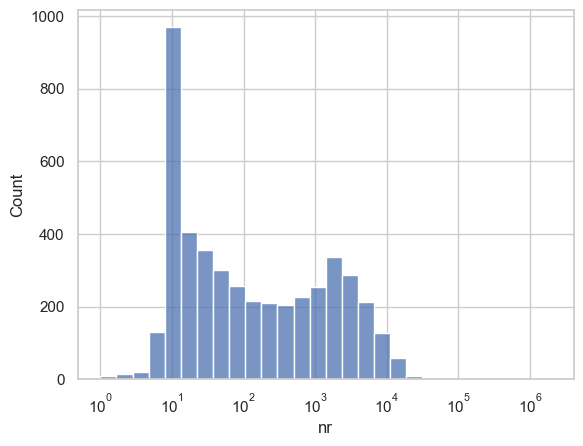

In [90]:
sns.histplot(player_stats["nr"], log_scale=True)

In [91]:
len(player_stats[player_stats["nr"] > 100]) / len(player_stats)

0.4703840312432198

In [96]:
good_players = player_stats[
    (player_stats["mean"] > 75)
    & (player_stats["std"] < 45)
    & (player_stats["nr"] > 200)
    ]
len(good_players) / len(player_stats)

0.3835973096116294

In [97]:
good_players

,id,mean,std,nr
0,0,78.433100,42.186764,1978858
1,6955,76.191936,41.780344,4241
2,54404,78.010880,41.985297,7445
3,74994,76.775460,41.428476,7669
4,56143,76.774029,41.546253,978
...,...,...,...,...
4102,80793,78.917933,41.848034,987
4120,51792,79.970339,42.504307,236
4129,80690,79.126394,41.886472,269
4251,30717,76.034985,40.692097,343


In [98]:
# games where 3/4 players are good
good_players = good_players["id"]

In [99]:
good_games = df[df["player_ids"].apply(lambda x: len(set(x) & set(good_players)) == 4)]
# good_games.head(2)
len(good_games) / len(df)

0.49013

In [105]:
all_good_games = pd.DataFrame()
all_games_len = 0
for df in tqdm(glob.glob("../data/swisslos/*.txt")):
    df = pd.read_json(df, lines=True)
    good_games = df[
        df["player_ids"].apply(lambda x: len(set(x) & set(good_players)) == 4)
    ]
    all_good_games = pd.concat([all_good_games, good_games])
    all_games_len += len(df)

100%|██████████| 19/19 [20:07<00:00, 63.57s/it] 


49.45612030350124

In [106]:
len(all_good_games) / all_games_len

0.5938932244639872

In [107]:
all_good_games.to_json("../data/swisslos/good_games.json", lines=True, orient="records")

In [3]:
all_good_games = pd.read_json(
    "../data/swisslos/good_games.json", lines=True, orient="records", nrows=100
)

In [4]:
all_good_games = all_good_games.head(100)
# game_json = all_good_games[all_good_games["game"].apply(lambda x: x["trump"] in [4, 5])]["game"].iloc[0]
game_json = all_good_games["game"].iloc[0]
game_json

{'version': 'V0.2',
 'trump': 1,
 'dealer': 2,
 'currentPlayer': -1,
 'forehand': 0,
 'tricks': [{'cards': ['HA', 'H9', 'H10', 'D10'],
   'points': 45,
   'win': 0,
   'first': 1},
  {'cards': ['CJ', 'CA', 'C7', 'C10'], 'points': 23, 'win': 3, 'first': 0},
  {'cards': ['S6', 'S10', 'SQ', 'S9'], 'points': 13, 'win': 1, 'first': 3},
  {'cards': ['SA', 'C6', 'H7', 'S7'], 'points': 11, 'win': 3, 'first': 1},
  {'cards': ['SK', 'SJ', 'S8', 'C8'], 'points': 6, 'win': 3, 'first': 3},
  {'cards': ['D7', 'DJ', 'HQ', 'DA'], 'points': 16, 'win': 1, 'first': 3},
  {'cards': ['D9', 'DK', 'HK', 'DQ'], 'points': 11, 'win': 3, 'first': 1},
  {'cards': ['HJ', 'C9', 'H6', 'D6'], 'points': 20, 'win': 3, 'first': 3},
  {'cards': ['H8', 'CQ', 'D8', 'CK'], 'points': 12, 'win': 3, 'first': 3}],
 'player': [{'hand': []}, {'hand': []}, {'hand': []}, {'hand': []}],
 'jassTyp': 'SCHIEBER'}

In [5]:
def reconstruct_hands(game_json):
    reconstructed_hands = {0: [], 1: [], 2: [], 3: []}

    for trick in game_json["tricks"]:
        cards = trick["cards"]
        first_player = trick["first"]

        # Determine the order of players for this trick
        for i in range(4):
            player = (first_player + i) % 4
            card = cards[i]
            reconstructed_hands[player].append(card)

    return reconstructed_hands


reconstructed_hands = reconstruct_hands(game_json)

for player, hand in reconstructed_hands.items():
    print(f"Player {player}'s reconstructed hand: {hand}")

Player 0's reconstructed hand: ['D10', 'CJ', 'S10', 'S7', 'SJ', 'DJ', 'DQ', 'C9', 'CQ']
Player 1's reconstructed hand: ['HA', 'CA', 'SQ', 'SA', 'S8', 'HQ', 'D9', 'H6', 'D8']
Player 2's reconstructed hand: ['H9', 'C7', 'S9', 'C6', 'C8', 'DA', 'DK', 'D6', 'CK']
Player 3's reconstructed hand: ['H10', 'C10', 'S6', 'H7', 'SK', 'D7', 'HK', 'HJ', 'H8']


In [6]:
def onehot_hand(hand):
    onehot = [0] * 36
    for card in hand:
        onehot[card_ids[card]] = 1
    return onehot


encoded_hand = onehot_hand(['D10', 'CJ', 'S10', 'S7', 'SJ', 'DJ', 'DQ', 'C9', 'CQ'])

assert len(encoded_hand) == 36
assert sum(encoded_hand) == 9

In [7]:
def generate_train_data(game_json):
    data = {0: [], 1: [], 2: [], 3: []}
    reconstructed_hands = reconstruct_hands(game_json)
    last_four_moves = np.ones((4, 4, 36)) * -1

    # points per team
    points = [sum(trick["points"] for trick in game_json["tricks"] if trick["win"] % 2 == i) for i in range(2)]

    for i, trick in enumerate(game_json["tricks"]):
        first_player = trick["first"]
        cards = trick["cards"]
        for j in range(4):
            player = (first_player + j) % 4
            card = cards[j]
            hand = reconstructed_hands[player]

            if trick["win"] == player:
                points[player % 2] -= trick["points"]

            data[player].append({
                "state": {
                    "hand": onehot_hand(hand),
                    "last_four_moves": last_four_moves,
                    "trump": game_json["trump"]
                },
                "action": onehot_hand([card]),
                "reward": points[player % 2],
            })

            last_four_moves = np.roll(last_four_moves, 1, axis=0)
            last_four_moves[0] = last_four_moves[1]  # move the last move to the first position
            if -1 not in last_four_moves[0]:
                last_four_moves[0] = np.ones((4, 36)) * -1

            last_four_moves[0][player] = onehot_hand([card])

            reconstructed_hands[player].remove(card)

        print(points)

    return data


_ = generate_train_data(game_json)

[0, 112]
[0, 89]
[0, 76]
[0, 65]
[0, 59]
[0, 43]
[0, 32]
[0, 12]
[0, 0]


In [8]:
df

NameError: name 'df' is not defined

In [9]:
def process_file(file):
    df = pd.read_json(file, lines=True)
    processed_data = pd.DataFrame()
    for game_json in tqdm(df["game"], desc="Games", leave=False):
        data = generate_train_data(game_json)
        for player in range(4):
            processed_data = pd.concat([processed_data, pd.DataFrame(data[player])])
    return processed_data


def save_to_json(data, filename):
    data.to_json(filename, orient="records", lines=True, mode='a')


files = glob.glob("../data/swisslos/*.txt")
output_file = "../data/swisslos/processed_data.json"

with ProcessPoolExecutor() as executor:
    for i, processed_data in enumerate(executor.map(process_file, files)):
        print(f"Saving results from file {i + 1} / {len(files)}")
        save_to_json(processed_data, output_file)

process_file(files[0])

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

In [ ]:
processed_data.to_json("../data/swisslos/processed_data.json", orient="records", lines=True)